In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

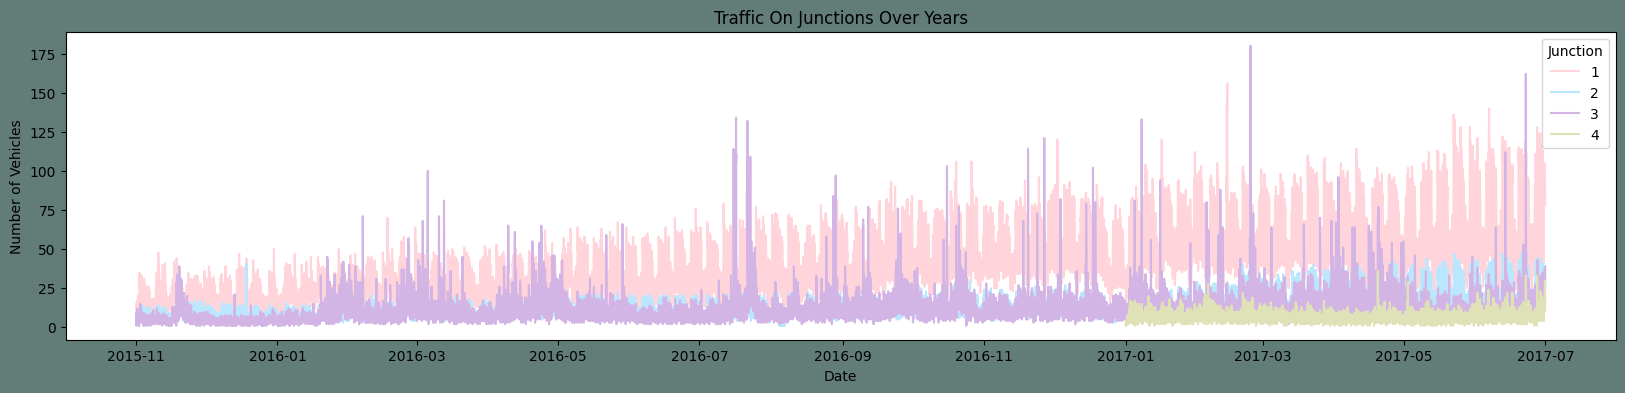

In [5]:
df=data.copy() 

colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [6]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


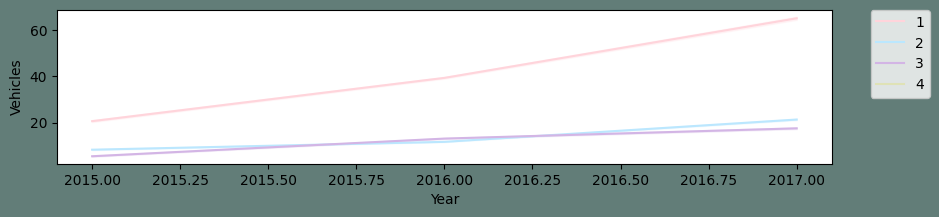

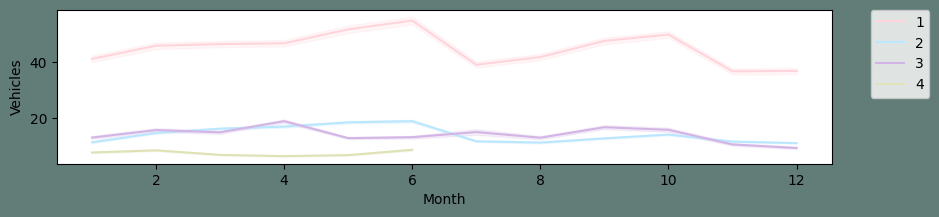

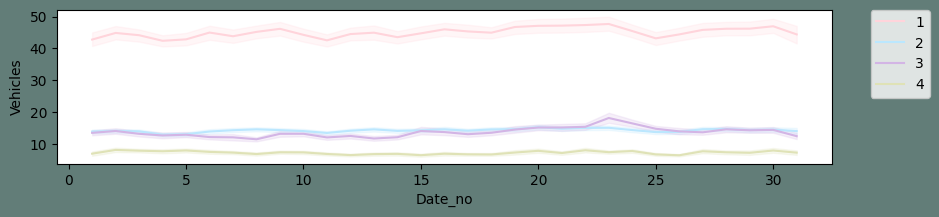

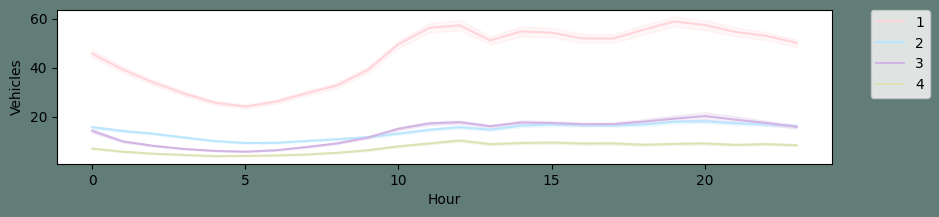

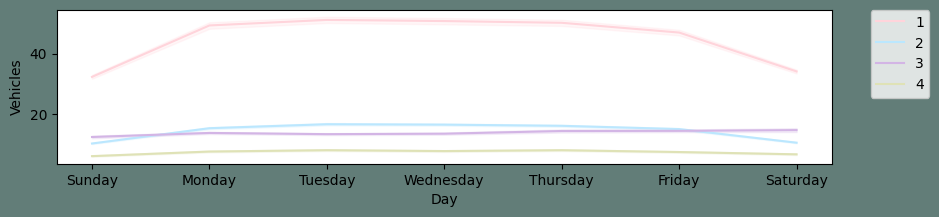

In [7]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

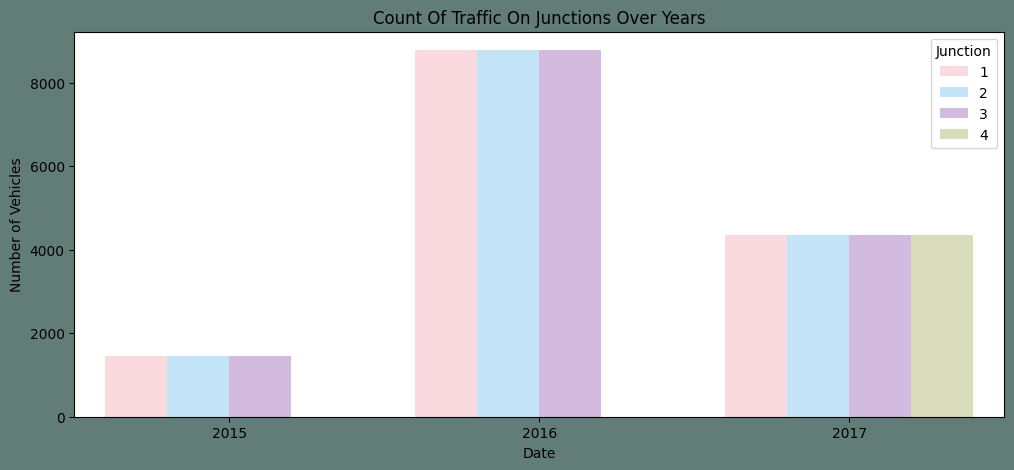

In [8]:


plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")



In [9]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

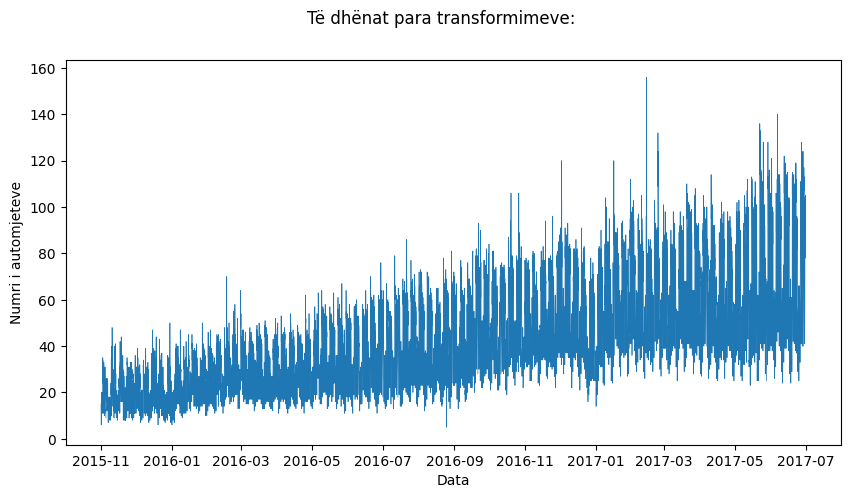

In [10]:
df_1 = df_J[[('Vehicles', 1)]]



list_dfs = [df_1]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

def Sub_Plots4(df_1, title):
    fig, axes = plt.subplots(1, 1, figsize=(10, 5), facecolor="#FFFFFF", sharey=True)
    fig.suptitle(title)
    # J1
    pl_1 = sns.lineplot(ax=axes, data=df_1,  linewidth="0.5")
    pl_1.set_ylabel("Numri i automjeteve") 
    pl_1.set_xlabel("Data")


Sub_Plots4(df_1.Vehicles, "Të dhënat para transformimeve:")

In [11]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff



In [12]:
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

In [13]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  


List_df_ND = [ df_N1["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415415
p-value: 4.798539876397025e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [14]:
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()


def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
J1_train, J1_test = Split_data(df_J1)



def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y


def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test


X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)



In [15]:
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))

    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer=tf.keras.optimizers.legacy.SGD(decay=1e-7, momentum=0.9), loss='mean_squared_error')

    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU


def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse


def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#FFFFFF")
    plt.plot(test,label="Vlera aktuale",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Vlera e parashikuar")
    plt.title("GRU - Vlera e parashikuar kundrejt vlerave aktuale")
    plt.xlabel("Data")
    plt.ylabel("Numri i automjeteve")
    plt.legend()
    plt.savefig("GRU_B.png")
    plt.show()

Epoch 1/50
87/87 [==============================] - 45s 240ms/step - loss: 0.0742
Epoch 2/50
87/87 [==============================] - 20s 228ms/step - loss: 0.0659
Epoch 3/50
87/87 [==============================] - 20s 229ms/step - loss: 0.0642
Epoch 4/50
87/87 [==============================] - 20s 225ms/step - loss: 0.0623
Epoch 5/50
87/87 [==============================] - 20s 226ms/step - loss: 0.0610
Epoch 6/50
87/87 [==============================] - 20s 227ms/step - loss: 0.0606
Epoch 7/50
87/87 [==============================] - 20s 229ms/step - loss: 0.0596
Epoch 8/50
87/87 [==============================] - 20s 228ms/step - loss: 0.0582
Epoch 9/50
87/87 [==============================] - 20s 230ms/step - loss: 0.0578
Epoch 10/50
87/87 [==============================] - 20s 230ms/step - loss: 0.0569
Epoch 11/50
87/87 [==============================] - 20s 231ms/step - loss: 0.0560
Epoch 12/50
87/87 [==============================] - 20s 232ms/step - loss: 0.0557
Epoch 13/50
8

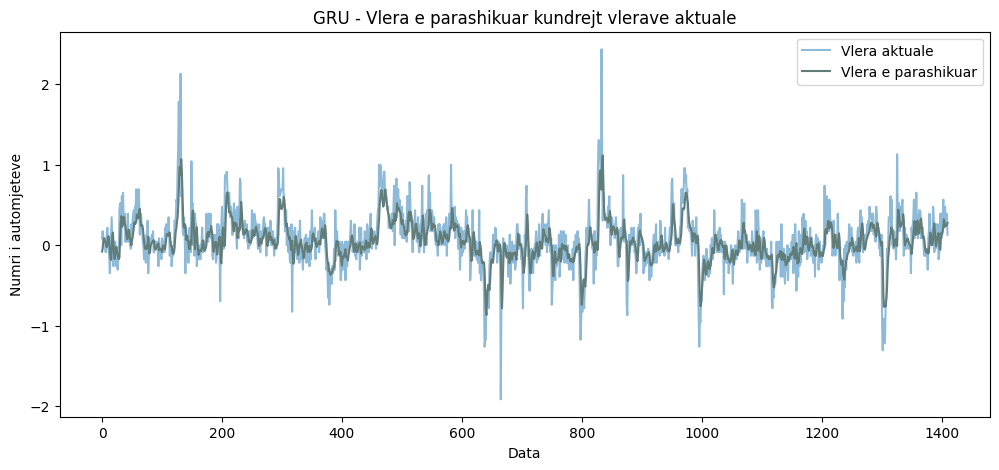

In [16]:
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [21]:
predictions_J1 = PredJ1


def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    mae = np.mean(np.abs(predicted - actual))
    return mse, rmse, mae


mse_J1, rmse_J1, mae_J1 = calculate_metrics(y_testJ1, predictions_J1)


print(f"Junction 1 - Mean Squared Error (MSE): {mse_J1}")
print(f"Junction 1 - Root Mean Squared Error (RMSE): {rmse_J1}")
print(f"Junction 1 - Mean Absolute Error (MAE): {mae_J1}")


Junction 1 - Mean Squared Error (MSE): 0.06130193628297519
Junction 1 - Root Mean Squared Error (RMSE): 0.24759227831855984
Junction 1 - Mean Absolute Error (MAE): 0.303976757857726
